In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Polymer Optimization - SA Score

>Polymer SA Score optimization

## Polymer SA Score Optimization

This notebook shows how to optimize a polymer generative model with respect to synthetic accessibility score. The use of SA score as a reward function can be swapped with any other reward function.

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.combichem import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Agent

Here we create the model we want to optimize. We will use the `LSTM_LM_Small_PI1M` model. This model was trained on the [PI1M polymer library](https://github.com/RUIMINMA1996/PI1M)

In [ ]:
agent = LSTM_LM_Small_PI1M(drop_scale=0.3, opt_kwargs={'lr':5e-5})

## Template

Here we create our template.

We set the following hard filters:
- `ValidityFilter`: screens for vaid compounds
- `SingleCompoundFilter`: screens for single compounds
- `AttachmentFilter`: ensures our polymers always have two attachment points, representing the polymerization locations
- `MolWtFilter`: constrains maximum monomer molecular weight
- `RingFilter`: constrains maximum monomer number of rings

We set the following soft filters:
- `SAFilter`: evaluates the SA score of a compound. By passing `score=PropertyFunctionScore(scale_sa)`, this filter returns the SA score scaled to between 0 and 1

In [ ]:
def scale_sa(sa):
    return (10-sa)/9

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     AttachmentFilter(min_val=2, max_val=2),
                     MolWtFilter(None, 600),
                     RingFilter(None, 4)
                     ],
                    [SAFilter(None, None, score=PropertyFunctionScore(scale_sa))], 
                    fail_score=-1., use_lookup=False)

template_cb = TemplateCallback(template, prefilter=True)

## Reward

We are only optimizing towards SA score, which is contained in our template. For this reason, we don't have any additional score terms

## Loss Function

We will use the `PPO` policy gradient algorithm

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

## Samplers

We create the following samplers:
- `sampler1 ModelSampler`: this samples from the main model
- `sampler2 ModelSampler`: this samples from the baseline model
- `sampler3 LogSampler`: this samples high scoring samples from the log
- `sampler4 CombichemSampler`: this sampler runs combichem generation on the top scoring compounds. The combination of generative models with combichem greatly accelerates finding high scoring compounds

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 400, 0., gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 400, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 98, 100)

mutators = [
    ChangeAtom(['6', '7', '8', '9']),
    AppendAtomSingle(['C', 'N', 'O', 'F', 'Cl', 'Br']),
    AppendAtomsDouble(['C', 'N', 'O']),
    DeleteAtom(),
    ChangeBond(),
    InsertAtomSingle(['C', 'N', 'O']),
    InsertAtomDouble(['C', 'N']),
    AddRing(),
    ShuffleNitrogen(10)
]

mc = MutatorCollection(mutators)

crossovers = [FragmentCrossover()]

cbc = CombiChem(mc, crossovers, template=template, rewards=[],
                prune_percentile=70, max_library_size=400, log=True, p_explore=0.2)

sampler4 = CombichemSampler(cbc, 20, 98, 0.2, 1, 'rewards', 'combichem')

samplers = [sampler1, sampler2, sampler3, sampler4]

## Other Callbacks

We add the following callbacks:
- `supervised_cb`: every 200 batches, this callback grabs the top 3% of samples from the log and runs supervised training with these samples
- `live_max`: prints the maximum score from `sampler1` each batch
- `live_p90`: prints the top 10% score from `sampler1` each batch

In [ ]:
supervised_cb = SupervisedCB(agent, 20, 0.5, 98, 1e-4, 64, epochs=2)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

## Environment

We create our environment with the objects assembled so far

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[], losses=[loss],
                 cbs=cbs)

## Train

In [ ]:
set_global_pool(min(10, os.cpu_count()))

In [ ]:
env.fit(128, 120, 300, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,PPO,rewards_live_p90,rewards_live_max
0,0.722,0.722,1.000,1.000,128,0.722,1.000,0.208,0.785,0.805
20,0.739,0.739,0.961,1.000,128,0.739,1.000,0.171,0.788,0.805
40,0.747,0.747,0.844,1.000,128,0.747,1.000,0.166,0.793,0.808
60,0.761,0.761,0.836,1.000,128,0.761,1.000,0.105,0.807,0.817
80,0.759,0.759,0.797,1.000,128,0.759,1.000,0.086,0.806,0.831
100,0.773,0.773,0.859,1.000,128,0.773,1.000,0.111,0.816,0.851
120,0.789,0.789,0.734,1.000,128,0.789,1.000,0.111,0.835,0.864
140,0.794,0.794,0.617,1.000,128,0.794,1.000,0.094,0.843,0.855
160,0.801,0.801,0.594,1.000,128,0.801,1.000,0.037,0.848,0.865
180,0.798,0.798,0.617,1.000,128,0.798,1.000,0.076,0.848,0.864


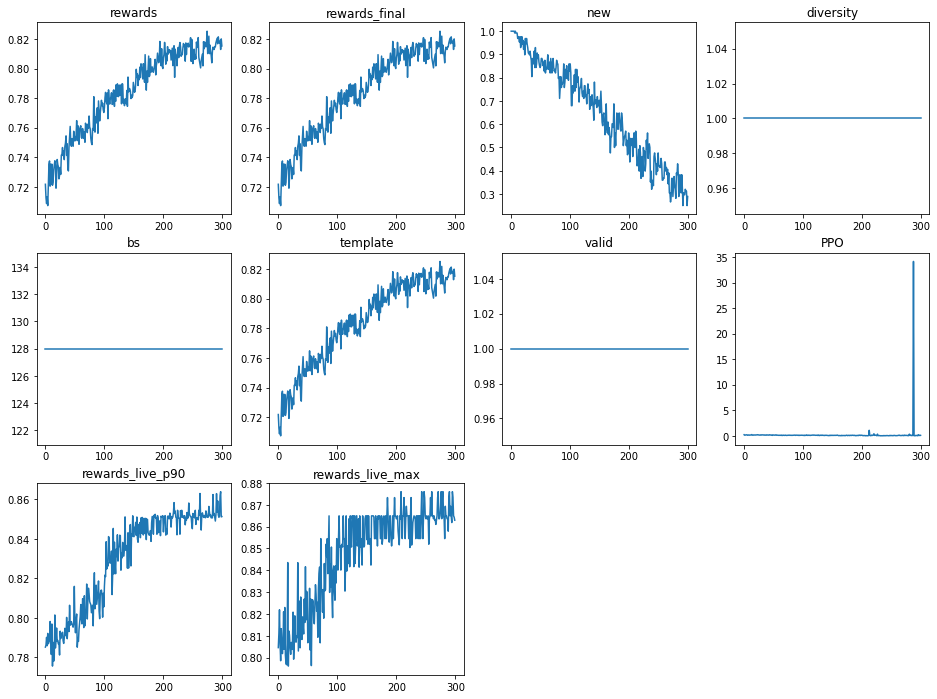

In [ ]:
env.log.plot_metrics()